In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date

In [2]:
# загрузим исходные данные о покупках
data = pd.read_csv('train.csv')

In [3]:
data

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
1,2,2015-03-22 09:25:46,14
2,2,2015-03-22 09:25:46,198
3,2,2015-03-22 09:25:46,88
4,2,2015-03-22 09:25:46,157
...,...,...,...
3123059,12702,2020-09-03 23:45:45,441
3123060,12702,2020-09-03 23:45:45,92
3123061,12702,2020-09-03 23:45:45,431
3123062,12702,2020-09-03 23:45:45,24


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123064 entries, 0 to 3123063
Data columns (total 3 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   user_id             int64 
 1   order_completed_at  object
 2   cart                int64 
dtypes: int64(2), object(1)
memory usage: 71.5+ MB


In [5]:
count_of_users = data['user_id'].nunique()
print(f"Количество уникальных клиентов: {count_of_users}")

Количество уникальных клиентов: 20000


In [6]:
# преобразуем дату в формат timestamp
data['date'] = (pd.to_datetime(data['order_completed_at']) - 
                datetime(1970, 1, 1)).dt.total_seconds().values.astype('int64')

In [7]:
data['day'] = pd.to_datetime(data['order_completed_at']).dt.date

In [8]:
data_min_date = data.day.min()
data_max_date = data.day.max()
print(f"Данные за период: с '{data_min_date}' по '{data_max_date}'")

Данные за период: с '2015-03-22' по '2020-09-03'


In [9]:
data['year'] = pd.to_datetime(data['order_completed_at']).dt.year
data['month'] = pd.to_datetime(data['order_completed_at']).dt.month

In [10]:
# динамика кол-ва клентов и выбираемых категорий по годам
data.groupby('year', as_index=False).agg({'user_id': 'nunique', 'cart': 'nunique'})

,year,user_id,cart
0,2015,6,36
1,2016,41,202
2,2017,109,300
3,2018,365,388
4,2019,6266,642
5,2020,20000,859


In [11]:
data['day_YM1'] = [date(x.year, x.month, 1) for x in data['day']]

In [12]:
# динамика кол-ва клентов и выбираемых категорий по годам + месяцам
grp_YM = data.groupby('day_YM1', as_index=False).agg(count_user=('user_id', 'nunique'), count_cart=('cart', 'nunique'))
grp_YM

,day_YM1,count_user,count_cart
0,2015-03-01,1,16
1,2015-06-01,1,1
2,2015-07-01,4,15
3,2015-08-01,1,2
4,2015-11-01,1,1
5,2015-12-01,1,12
6,2016-04-01,3,18
7,2016-05-01,4,32
8,2016-06-01,2,10
9,2016-07-01,6,47


<AxesSubplot:xlabel='day_YM1'>

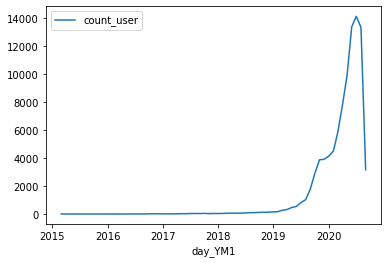

In [13]:
grp_YM.plot(x='day_YM1', y='count_user', kind='line')

<AxesSubplot:xlabel='day_YM1'>

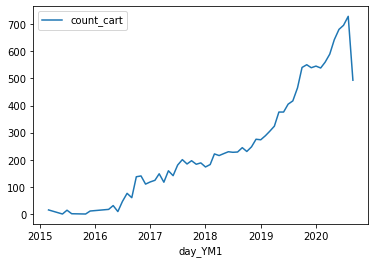

In [14]:
grp_YM.plot(x='day_YM1', y='count_cart', kind='line')

Чтобы прогнозировать будущие покупки, нужно научиться это делать на имеющихся данных. Для этого для каждого клиента попробуем предсказать его последнюю покупку по предыдущим, и сравним с имеющейся реальной информацией о его последней покупке.

Предположим, что, если клиент выбирает определенную категорию чаше, то и вероятность того, что в следующий раз он возьмет эту же категорию выше.

Второе предположение: если категория пользуется популярностью у большого числа клиентов, то существует высокая вероятность того, что отдельно взятый клиент тоже может выбрать такую категорию в следующий раз, даже если никогда до этого ее не брал.

In [15]:
# для каждого клиента разделим все данные на две части: данные для анализа без последней покупки
# и данные о последней покупке (данные для разметки - была покупка или нет)
users_period = data.groupby('user_id', as_index=False).agg(beg_date = ('day_YM1', 'min'), end_date = ('day_YM1', 'max'))
data_for_analysis = pd.merge(data, users_period, on='user_id', how='left')
data_for_markup = data_for_analysis[data_for_analysis['day_YM1'] == data_for_analysis['end_date']]
data_for_analysis = data_for_analysis[data_for_analysis['day_YM1'] != data_for_analysis['end_date']]

In [16]:
# определим предпочтения клиентов, т.е. определим долю категории в общем списке категорий, которые клиент выбрал
# за весь период своих покупок, без учета последней)
users_orders = data_for_analysis.groupby(['user_id'], as_index=False).agg(total_orders = ('day_YM1', 'nunique'))
users_carts = data_for_analysis.groupby(['user_id', 'cart'], as_index=False).agg(count_orders = ('cart', 'count'))
data_for_analysis = pd.merge(data_for_analysis, users_orders, on='user_id', how='left')
data_for_analysis = pd.merge(data_for_analysis, users_carts, on=['user_id', 'cart'], how='left')
data_for_analysis['preference'] = data_for_analysis['count_orders'] / data_for_analysis['total_orders']

In [17]:
# добавим информацию о популярности категории, т.е. для каждой категории оределим долю клиентов, которые ее выбрали
# из общего числа клиентов (на тот момент когда она приобреталась)
total_users = data_for_analysis.groupby(['day_YM1'], as_index=False).agg(total_users = ('user_id', 'nunique'))
carts_users = data_for_analysis.groupby(['day_YM1', 'cart'], as_index=False).agg(count_users = ('user_id', 'nunique'))
data_for_analysis = pd.merge(data_for_analysis, total_users, on=['day_YM1'], how='left')
data_for_analysis = pd.merge(data_for_analysis, carts_users, on=['day_YM1', 'cart'], how='left')
data_for_analysis['popularity'] = data_for_analysis['count_users'] / data_for_analysis['total_users']

In [18]:
# выполним группировку по паре клиенту-категории, 
# т.к. за выбранный период могло быть совершено несколько покупок одним и тем же клиентом, 
# и покупать он мог несколько раз одну и ту же категорию
data_for_markup = data_for_markup.groupby(['user_id', 'cart'], as_index=False).agg(count_cart = ('cart', 'count'))
data_for_markup.drop('count_cart', axis=1, inplace=True)
data_for_markup.insert(0, 'target', 1)

In [19]:
# такое соединение двух датасетов даст информацию о категориях, которые клиент не выбрал в последний раз
# (из числа тех, которые он когда-либо покупал)
data_for_markup = pd.merge(data_for_markup[['user_id', 'cart', 'target']],
                           data_for_analysis,
                           on=['user_id', 'cart'],
                           how='right').fillna(0)
data_for_markup = data_for_markup.astype({'target': int})

# сформируем составной идентификатор id - пара (user-cat)
data_for_markup['id'] = data_for_markup['user_id'].apply(str) + ';' + data_for_markup['cart'].apply(str)

In [20]:
data_for_markup

,user_id,cart,target,order_completed_at,date,day,year,month,day_YM1,beg_date,end_date,total_orders,count_orders,preference,total_users,count_users,popularity,id
0,2,399,0,2015-03-22 09:25:46,1427016346,2015-03-22,2015,3,2015-03-01,2015-03-01,2020-06-01,7,1,0.142857,1,1,1.000000,2;399
1,2,14,0,2015-03-22 09:25:46,1427016346,2015-03-22,2015,3,2015-03-01,2015-03-01,2020-06-01,7,1,0.142857,1,1,1.000000,2;14
2,2,198,0,2015-03-22 09:25:46,1427016346,2015-03-22,2015,3,2015-03-01,2015-03-01,2020-06-01,7,2,0.285714,1,1,1.000000,2;198
3,2,198,0,2018-01-12 23:36:19,1515800179,2018-01-12,2018,1,2018-01-01,2015-03-01,2020-06-01,7,2,0.285714,37,5,0.135135,2;198
4,2,88,0,2015-03-22 09:25:46,1427016346,2015-03-22,2015,3,2015-03-01,2015-03-01,2020-06-01,7,2,0.285714,1,1,1.000000,2;88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2603241,16572,179,0,2020-08-31 22:38:42,1598913522,2020-08-31,2020,8,2020-08-01,2020-06-01,2020-09-01,3,1,0.333333,2723,452,0.165993,16572;179
2603242,16572,67,0,2020-08-31 22:38:42,1598913522,2020-08-31,2020,8,2020-08-01,2020-06-01,2020-09-01,3,1,0.333333,2723,430,0.157914,16572;67
2603243,3918,526,0,2020-08-31 23:34:03,1598916843,2020-08-31,2020,8,2020-08-01,2019-09-01,2020-09-01,12,1,0.083333,2723,1,0.000367,3918;526
2603244,3918,656,0,2020-08-31 23:34:03,1598916843,2020-08-31,2020,8,2020-08-01,2019-09-01,2020-09-01,12,1,0.083333,2723,2,0.000734,3918;656


In [21]:
X_data = data_for_markup[['id', 'user_id', 'cart', 'preference', 'popularity', 'target']]
X_data

,id,user_id,cart,preference,popularity,target
0,2;399,2,399,0.142857,1.000000,0
1,2;14,2,14,0.142857,1.000000,0
2,2;198,2,198,0.285714,1.000000,0
3,2;198,2,198,0.285714,0.135135,0
4,2;88,2,88,0.285714,1.000000,0
...,...,...,...,...,...,...
2603241,16572;179,16572,179,0.333333,0.165993,0
2603242,16572;67,16572,67,0.333333,0.157914,0
2603243,3918;526,3918,526,0.083333,0.000367,0
2603244,3918;656,3918,656,0.083333,0.000734,0


In [22]:
X_data.id.nunique()

952536

In [23]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [24]:
X = X_data.drop(['id', 'target'], axis=1)
y = X_data['target']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Запустим пробный вариант: классификатор с параметрами по умолчанию.

In [26]:
rf_cls = RandomForestClassifier(n_estimators=20, random_state=42)
rf_cls.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20, random_state=42)

In [27]:
y_pred = rf_cls.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88    304166
           1       0.86      0.79      0.82    216484

    accuracy                           0.86    520650
   macro avg       0.86      0.85      0.85    520650
weighted avg       0.86      0.86      0.86    520650



In [28]:
# посмотрим на важность каждой характеристики
feats = {}
for feature, importance in zip(X.columns, rf_cls.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
importances

,Features,Importance
0,user_id,0.529210
1,preference,0.252282
2,popularity,0.136968
3,cart,0.081541


Проведем автоматиеский подбор гиперпараметров (работает очень долго, поэтому закомментарил)

In [29]:
# n_estimators = [int(x) for x in np.linspace(start = 210, stop = 240, num = 10)]
# max_features = ['sqrt'] # ['log2', 'sqrt']
# max_depth = [8, 10, 12, 14, 16] # [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)]
# min_samples_split = [5, 6, 7, 8, 9, 10] # [int(x) for x in np.linspace(start = 2, stop = 20, num = 5)]
# min_samples_leaf = [5, 6, 7, 8, 9, 10] # [int(x) for x in np.linspace(start = 2, stop = 20, num = 5)]
# bootstrap = [False] #[True, False]
# param_dist = {'n_estimators': n_estimators,
#               'max_features': max_features,
#               'max_depth': max_depth,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf,
#               'bootstrap': bootstrap}
# rs = RandomizedSearchCV(rf_cls, 
#                         param_dist, 
#                         n_iter=10, #100, 
#                         cv=3, 
#                         verbose=1, 
#                         n_jobs=-1, 
#                         random_state=42)
# rs.fit(X_train, y_train)
# rs.best_params_

# y_pred_rs = rs.best_estimator_.predict(X_test)
# print(classification_report(y_test, y_pred_rs))

Один из лучших вариантов подбора следующий набор параметров:

 {'n_estimators': 223,
 'min_samples_split': 6,
 'min_samples_leaf': 6,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': False}

In [30]:
rf_cls = RandomForestClassifier(n_estimators=223, 
                                min_samples_split=6, 
                                min_samples_leaf=6, 
                                max_features='sqrt', 
                                max_depth=10, 
                                bootstrap=False, 
                                random_state=42)
rf_cls.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=10, max_features='sqrt',
                       min_samples_leaf=6, min_samples_split=6,
                       n_estimators=223, random_state=42)

In [31]:
y_pred = rf_cls.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.80      0.77    304166
           1       0.68      0.60      0.64    216484

    accuracy                           0.72    520650
   macro avg       0.71      0.70      0.70    520650
weighted avg       0.71      0.72      0.71    520650



*) Примечание: здесь метрика F1 меньше, но при проверке на тестовом наборе данных в системе дает лучший результат.

In [32]:
# посмотрим на важность каждой характеристики после подбора гиперпараметров
feats = {}
for feature, importance in zip(X.columns, rf_cls.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
importances

,Features,Importance
0,preference,0.677367
1,popularity,0.228454
2,cart,0.058536
3,user_id,0.035644


Примечательно, что после подбора гиперпараметров классификатора, важность характеристик изменилась.

Имея обученную модель, можно предсказать следущие покупки клиентов.

По условиям задания список клиент-категория для предсказания нужно взять из файла sample_submission.csv.

In [33]:
submission = pd.read_csv('sample_submission.csv')

In [34]:
submission

,id,target
0,0;133,0
1,0;5,1
2,0;10,0
3,0;396,1
4,0;14,0
...,...,...
790444,19998;26,0
790445,19998;31,0
790446,19998;29,1
790447,19998;798,1


In [35]:
submission['user_id'] = [int(x.split(';')[0]) for x in submission['id']]
submission['cart'] = [int(x.split(';')[1]) for x in submission['id']]

In [36]:
submission.user_id.nunique()

13036

Проведем похожие подготовительные действия для датасета submission, но теперь на всех данных о предшевствующих покупках.

In [37]:
# информация о предпочтениях клиентов
users_orders = data.groupby(['user_id'], as_index=False).agg(total_orders = ('day_YM1', 'nunique'))
users_carts = data_for_analysis.groupby(['user_id', 'cart'], as_index=False).agg(count_orders = ('cart', 'count'))
data_for_analysis = pd.merge(data, users_orders, on='user_id', how='left')
data_for_analysis = pd.merge(data_for_analysis, users_carts, on=['user_id', 'cart'], how='left')
data_for_analysis['preference'] = data_for_analysis['count_orders'] / data_for_analysis['total_orders']

In [38]:
# информация о популярности категории
total_users = data_for_analysis.groupby(['day_YM1'], as_index=False).agg(total_users = ('user_id', 'nunique'))
carts_users = data_for_analysis.groupby(['day_YM1', 'cart'], as_index=False).agg(count_users = ('user_id', 'nunique'))
data_for_analysis = pd.merge(data_for_analysis, total_users, on=['day_YM1'], how='left')
data_for_analysis = pd.merge(data_for_analysis, carts_users, on=['day_YM1', 'cart'], how='left')
data_for_analysis['popularity'] = data_for_analysis['count_users'] / data_for_analysis['total_users']

In [39]:
data_for_markup = pd.merge(submission[['user_id', 'cart', 'target']],
                           data_for_analysis,
                           on=['user_id', 'cart'],
                           how='left').fillna(0)
data_for_markup = data_for_markup.astype({'target': int})

data_for_markup['id'] = data_for_markup['user_id'].apply(str) + ';' + data_for_markup['cart'].apply(str)

In [40]:
# оставим сведения только об одной паре (user-cat)
users_carts_max_date = data_for_markup.groupby(['user_id', 'cart'], as_index=False).agg(max_date = ('date', 'max'))
data_for_markup = pd.merge(data_for_markup, users_carts_max_date, on=['user_id', 'cart'], how='left')
data_for_markup = data_for_markup[data_for_markup['date'] == data_for_markup['max_date']]

data_for_markup = data_for_markup.drop_duplicates()

In [41]:
X_data = data_for_markup[['id', 'user_id', 'cart', 'preference', 'popularity', 'target']]

In [42]:
X_sub = X_data.drop(['id', 'target'], axis=1)
X_sub

,user_id,cart,preference,popularity
0,0,133,0.333333,0.018348
1,0,5,0.333333,0.277016
2,0,10,0.333333,0.120872
3,0,396,0.333333,0.213061
5,0,14,0.666667,0.599041
...,...,...,...,...
2395651,19998,26,0.500000,0.166629
2395652,19998,31,0.500000,0.155695
2395653,19998,29,0.500000,0.203700
2395654,19998,798,0.000000,0.106658


In [43]:
# запустим обученную модель
y_sub = rf_cls.predict(X_sub)

In [44]:
X_sub['id'] = X_data['id']
X_sub['target'] = y_sub

In [45]:
X_sub_out = X_sub.drop(['user_id', 'cart', 'preference', 'popularity'], axis=1)

In [46]:
X_sub_out

,id,target
0,0;133,0
1,0;5,0
2,0;10,0
3,0;396,0
5,0;14,1
...,...,...
2395651,19998;26,0
2395652,19998;31,0
2395653,19998;29,0
2395654,19998;798,0


In [47]:
# запишем полученные данные в файл
X_sub_out.to_csv('submission_RF.csv', index=False, sep=',')